# **Market Stock Prediction Using Batch Learning**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import plotly

In [2]:
data = pd.read_csv('./data/BTCUSDT.csv', index_col=0)
data.index = pd.to_datetime(data['date'])
data = data.drop(columns=['date'])
data.shape

(1000, 5)

In [3]:
data.head()

,open,high,low,close,volume
date,,,,,
2022-04-29,39742.06,39925.25,38175.00,38596.11,51453.65715
2022-04-30,38596.11,38795.38,37578.20,37630.80,35321.18989
2022-05-01,37630.80,38675.00,37386.38,38468.35,38812.24104
2022-05-02,38468.35,39167.34,38052.00,38525.16,53200.92628
2022-05-03,38525.16,38651.51,37517.80,37728.95,40316.45358


In [4]:
data.index.max(), data.index.min() 

(Timestamp('2025-01-22 00:00:00'), Timestamp('2022-04-29 00:00:00'))

What we want to predict/forcast is the close price.

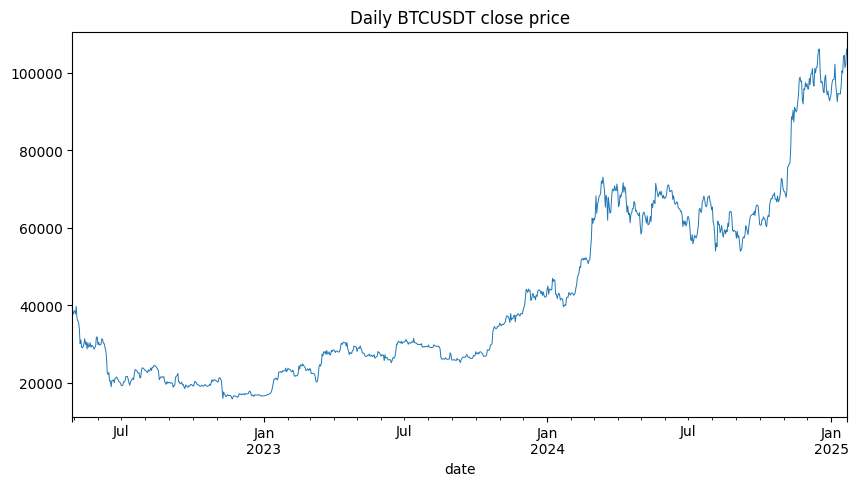

In [5]:
plt.figure(figsize=(10, 5))
data['close'].plot(linewidth=0.7)
plt.title("Daily BTCUSDT close price")
plt.show()


In [6]:
data['close'].describe()


count      1000.000000
mean      42251.597050
std       23294.107111
min       15781.290000
25%       23545.567500
50%       30291.730000
75%       62065.000000
max      106143.820000
Name: close, dtype: float64

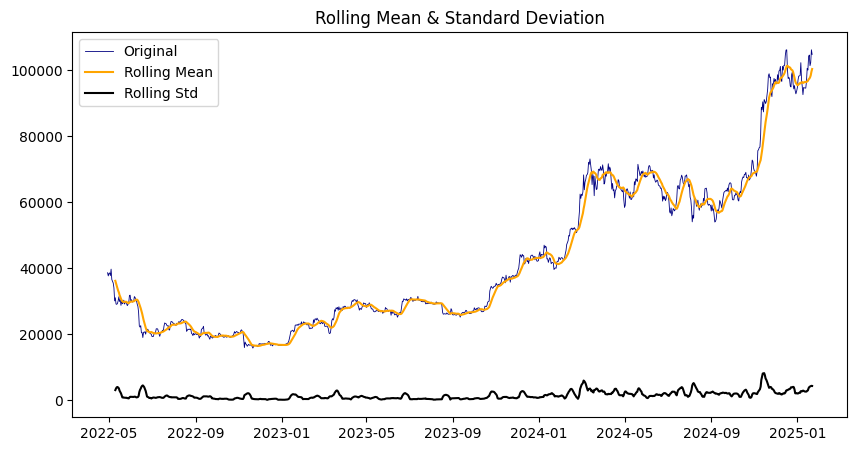

Results of Dickey-Fuller Test:
Test Statistic                   1.334427
p-value                          0.996795
#Lags Used                       6.000000
Number of Observations Used    993.000000
Critical Value (1%)             -3.436953
Critical Value (5%)             -2.864455
Critical Value (10%)            -2.568322
dtype: float64


In [7]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    # Plot rolling statistics:
    plt.figure(figsize=(10, 5))
    orig = plt.plot(timeseries, color='navy',label='Original', linewidth=0.6)
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC') #autolag = 'AIC' is the Akaike Information Criterion
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(data['close'])


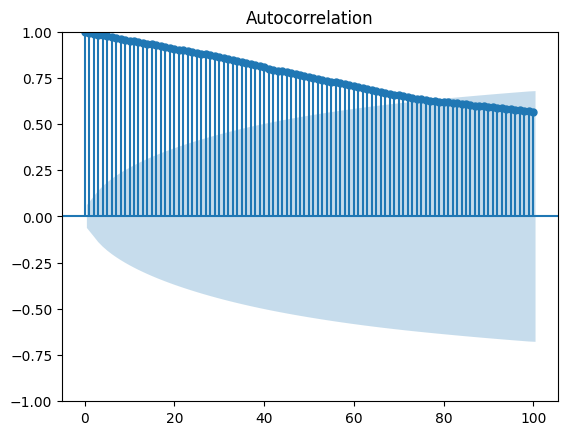

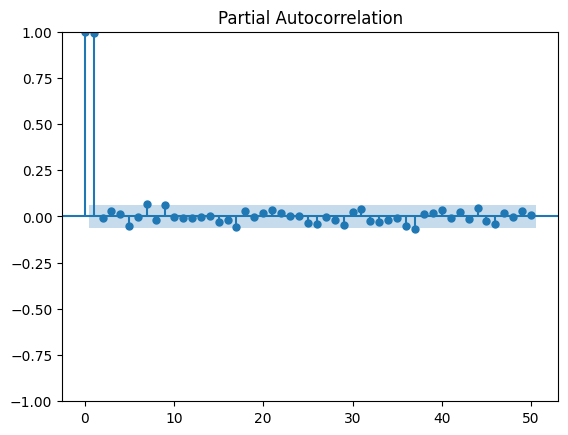

In [8]:
plot_acf(data['close'], lags=100)
plt.show()
plot_pacf(data['close'], lags=50)
plt.show()


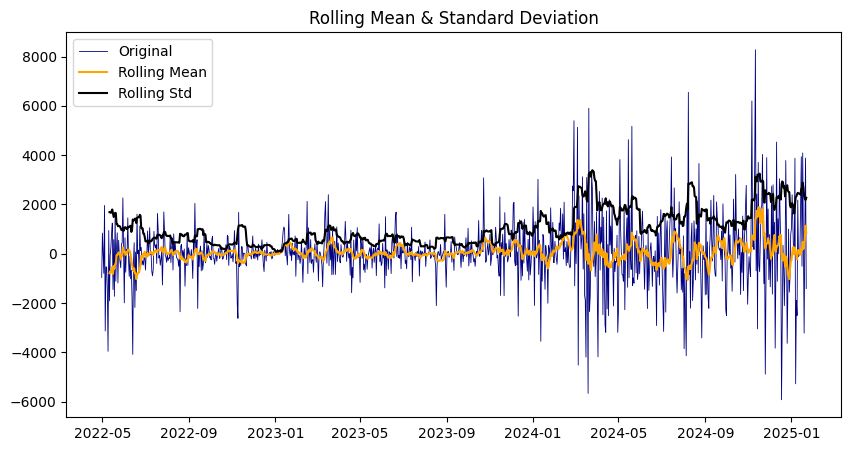

Results of Dickey-Fuller Test:
Test Statistic                -1.357013e+01
p-value                        2.223139e-25
#Lags Used                     5.000000e+00
Number of Observations Used    9.930000e+02
Critical Value (1%)           -3.436953e+00
Critical Value (5%)           -2.864455e+00
Critical Value (10%)          -2.568322e+00
dtype: float64


In [9]:
diff = data['close'].diff().dropna()
test_stationarity(diff)


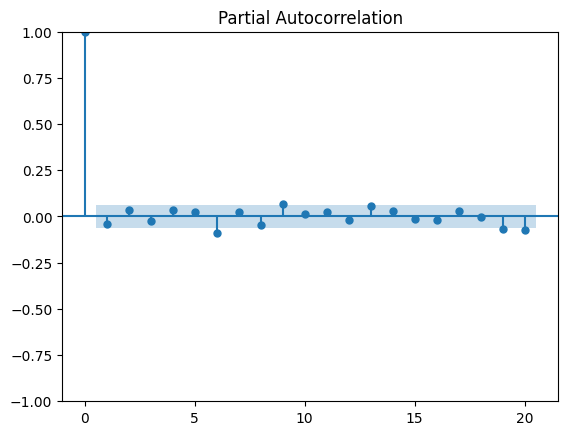

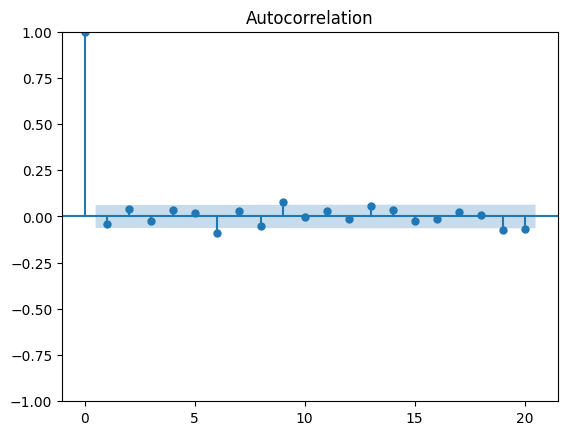

In [10]:
plot_pacf(diff, lags=20)
plt.show()
plot_acf(diff, lags=20)
plt.show()

So we will adopt a model : p = 1, d = 1, q = 1

In [11]:
y_train, y_test = data['close'][:int(len(data)*0.7)], data['close'][int(len(data)*0.7):]
x_train, x_test = data.drop('close', axis=1)[:int(len(data)*0.7)], data.drop('close', axis=1)[int(len(data)*0.7):]

In [12]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((700, 4), (300, 4), (700,), (300,))

In [13]:
y_train.head()

date
2022-04-29    38596.11
2022-04-30    37630.80
2022-05-01    38468.35
2022-05-02    38525.16
2022-05-03    37728.95
Name: close, dtype: float64

In [14]:
import plotly.graph_objects as go
import numpy as np
# PLOT PREDICTIONS 
def Go_plot_predictions(model_fit, data, y_train, y_test, x_test):
    fig_predictions = go.Figure()

    # Real data
    fig_predictions.add_trace(go.Scatter(
        y=data['close'], 
        mode='lines', 
        line=dict(color='black', width=1.3),
        name='Real'
    ))

    # Predicted data
    fitted_values = model_fit.fittedvalues
    forecast_values = model_fit.forecast(steps=len(y_test), exog=x_test.values)
    predicted = np.concatenate([fitted_values, forecast_values])
    fig_predictions.add_trace(go.Scatter(
        y=predicted,
        mode='lines',
        line=dict(color='orange', width=1.3),
        name='Predicted'
    ))

    # Layout settings
    fig_predictions.update_layout(
        title='ARIMAX Model Forecasting of BTCUSDT Close Price',
        xaxis_title='Time',
        yaxis_title='Value',
        template='plotly_white',
        height=600,
        width=900
    )
    # divide the graph into two parts a left part for training data and a right part for testing data, fill the part with different colors
    fig_predictions.add_shape(
        type="rect",
        x0=0,
        x1=len(y_train),
        y0=0,
        y1=data['close'].max(),
        line=dict(width=0),
        fillcolor="LightSkyBlue",
        opacity=0.1,
        layer="below", 
        name='Training phase'
    )

    fig_predictions.add_shape(
        type="rect",
        x0=len(y_train),
        x1=len(data),
        y0=0,
        y1=data['close'].max(),
        line=dict(width=0),
        fillcolor="LightCoral",
        opacity=0.1,
        layer="below", 
        name='Testing phase'
    )

    fig_predictions.show()
    # PLOT RESIDUALS
    fig_residuals = go.Figure()

    # Residuals data
    fig_residuals.add_trace(go.Scatter(
        y= np.concatenate([model_fit.resid, - forecast_values + y_test]),
        mode='lines',
        line=dict(color='purple', width=0.7),
        name='Residuals'
    ))

    # Layout settings
    fig_residuals.update_layout(
        title='ARIMA Model Residuals',
        xaxis_title='Time',
        yaxis_title='Residuals',
        template='plotly_white',
        height=600,
        width=850
    )

    fig_residuals.show()

In [15]:
# metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def metrics(y_true, y_pred):
    mse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, r2, mape

    - Seasonal ARIMA model

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(y_train.values, order=(1,1,1))#, exog= x_train.values)
model_fit = model.fit()

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5779.810
Date:                Wed, 22 Jan 2025   AIC                          11565.621
Time:                        23:21:17   BIC                          11579.270
Sample:                             0   HQIC                         11570.897
                                - 700                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3058      0.209     -1.460      0.144      -0.716       0.105
ma.L1          0.2166      0.208      1.039      0.299      -0.192       0.625
sigma2      8.946e+05   2.09e+04     42.705      0.000    8.54e+05    9.36e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              2453.58
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:

Go_plot_predictions(model_fit, data, y_train, y_test, x_test)

In [19]:
mse, mae, r2, mape = metrics(y_test, model_fit.forecast(steps=len(y_test)))
print("Test metrics FOR SARIMA:")
print(f'RMSE: {mse}\nMAE: {mae}\nR2: {r2}\nMAPE: {mape}')


Test metrics FOR SARIMA:
RMSE: 14890.304475698445
MAE: 11593.608681343516
R2: -0.010047550526864457
MAPE: 0.150160597584917


    - ARIMAX

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(y_train.values, order=(1,1,1), exog=x_train.values)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5090.981
Date:                Wed, 22 Jan 2025   AIC                          10195.963
Time:                        23:22:39   BIC                          10227.810
Sample:                             0   HQIC                         10208.274
                                - 700                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5341      0.018    -29.937      0.000      -0.569      -0.499
x2             0.8535      0.018     47.114      0.000       0.818       0.889
x3             0.6783      0.015     45.078      0.000       0.649       0.708
x4            -0.0002      0.000     -1.056      0.291      -0.001       0.000
ar.L1         -0.0616      0.036     -1.701      0.089      -0.133       0.009
ma.L1         -0.9878      0.014    -70.105      0.000      -1.015      -0.960
sigma2      1.726e+05   1.69e-08   1.02e+13      0.000    1.73e+05    1.73e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               666.02
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.69e+30. Standard errors may be unstable.
"""

In [21]:
Go_plot_predictions(model_fit, data, y_train, y_test, x_test)

In [22]:

mse, mae, r2, mape = metrics(y_test, model_fit.forecast(steps=len(y_test), exog=x_test.values))
print("Test metrics FOR SARIMAX:")
print(f'RMSE: {mse}\nMAE: {mae}\nR2: {r2}\nMAPE: {mape}')


Test metrics FOR SARIMAX:
RMSE: 752.0457244917677
MAE: 530.2701089487332
R2: 0.9974235414711199
MAPE: 0.0073478389556827185


We conclude that the multiple linear regression model is the best model for this dataset.

In [23]:
# Use prophet model to predict the future price of BTCUSDT
from prophet import Prophet

m = Prophet()

data_prophet = pd.DataFrame(y_train)
data_prophet['ds'] = data_prophet.index
data_prophet.columns = ['y', 'ds']
m.fit(data_prophet)


c:\Users\akilh\OneDrive\Bureau\TELECOM_3A\DataScience-X\DataStreamProcessing\project\StockMarketPrediction\myvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

23:23:14 - cmdstanpy - INFO - Chain [1] start processing
23:23:14 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
y_test_prophet = pd.DataFrame(y_test)
y_test_prophet['ds'] = y_test_prophet.index
y_test_prophet.columns = ['y', 'ds']

future = m.make_future_dataframe(periods=len(y_test))
future.tail()


,ds
995,2025-01-18
996,2025-01-19
997,2025-01-20
998,2025-01-21
999,2025-01-22


In [25]:
forcast = m.predict(future)
forcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
995,2025-01-18,127592.831177,107610.132433,149376.317176
996,2025-01-19,127877.445967,107760.273756,149996.402763
997,2025-01-20,128203.594843,107803.595449,150428.904500
998,2025-01-21,128377.383314,108052.950760,149795.870240
999,2025-01-22,128739.466413,108286.009870,151761.674676


In [26]:
from prophet.plot import plot_plotly, plot_components_plotly

fig = plot_plotly(m, forcast, xlabel='Date', ylabel='Close Price')
fig.show()


In [27]:
# plot using plotly the close price and the forecasted price
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['close'], 
    mode='lines', 
    line=dict(color='brown', width=1.3),
    name='Real'
))

fig.add_trace(go.Scatter(
    x=forcast['ds'], 
    y=forcast['yhat'], 
    mode='lines', 
    line=dict(color='orange', width=1.3),
    name='Predicted'
))

fig.update_layout(
    title='Prophet Model Forecasting of BTCUSDT Close Price',
    xaxis_title='Time',
    yaxis_title='Value',
    template='plotly_white',
    height=600,
    width=900
)

fig.show()